In [0]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
%%capture
!pip install --upgrade tensorflow

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


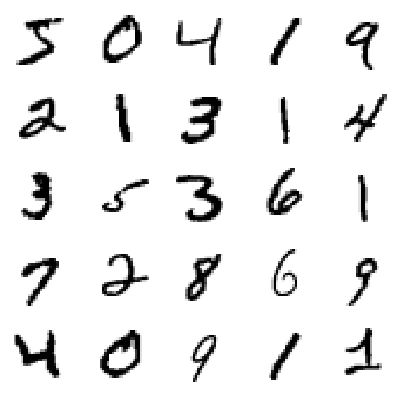

In [0]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(5*5):
    # define subplot
    pyplot.subplot(5, 5, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [0]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy.random import normal
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import clear_session
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(32,kernel_size=3,strides=2,padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=latent_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2,padding='same'))
    model.add(Activation('tanh'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'plots/MNIST/GAN_MNIST_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, tensorboard, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, d_real_acc = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, d_fake_acc = d_model.evaluate(X_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('Evaluation du discriminateur : epoch: %d, acc_real: %.0f%%, acc_fake: %.0f%%' % (epoch, d_real_acc*100, d_fake_acc*100))
    logs = {
            'd_real_acc':d_real_acc*100,
            'd_fake_acc':d_fake_acc*100
            }
    tensorboard.on_epoch_end(epoch, logs)
    # save plot
    save_plot(X_fake, epoch)
    # save the generator model tile file
    filename = 'models/MNIST/GAN_MNIST_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, tensorboard, n_epochs=100, batch_size=256):
    bat_per_epo = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # evaluate the model performance, sometimes
        summarize_performance(i, g_model, d_model, dataset, latent_dim, tensorboard)
        # enumerate batches over the training set
        for j in range(batch_size):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_real_loss, d_real_acc = d_model.train_on_batch(X_real, y_real)
            d_fake_loss, d_fake_acc = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, batch_size)
            # create inverted labels for the fake samples
            y_gan = ones((batch_size, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            # print('epoch : %d, batch : %d/%d, d_real_loss=%.3f, d_fake_loss=%.3f, g_loss=%.3f' % (i+1, j+1, batch_size, d_real_loss, d_fake_loss, g_loss))

# Delete all ever created models in the backend of this session
clear_session()
# Create the TensorBoard callback, which we will drive manually
tensorboard = TensorBoard(
  log_dir='/content/drive/My Drive/Colab Notebooks/logs/MNIST/GAN/',
  histogram_freq=0,
  write_graph=True
)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
tensorboard.set_model(gan_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, tensorboard)
tensorboard.on_train_end(None)

Evaluation du discriminateur : epoch: 0, acc_real: 2%, acc_fake: 77%
Evaluation du discriminateur : epoch: 1, acc_real: 100%, acc_fake: 100%
Evaluation du discriminateur : epoch: 2, acc_real: 94%, acc_fake: 100%
Evaluation du discriminateur : epoch: 3, acc_real: 16%, acc_fake: 0%
Evaluation du discriminateur : epoch: 4, acc_real: 0%, acc_fake: 0%
Evaluation du discriminateur : epoch: 5, acc_real: 1%, acc_fake: 0%
Evaluation du discriminateur : epoch: 6, acc_real: 19%, acc_fake: 0%
Evaluation du discriminateur : epoch: 7, acc_real: 43%, acc_fake: 26%
Evaluation du discriminateur : epoch: 8, acc_real: 52%, acc_fake: 100%
Evaluation du discriminateur : epoch: 9, acc_real: 48%, acc_fake: 100%
Evaluation du discriminateur : epoch: 10, acc_real: 66%, acc_fake: 100%
Evaluation du discriminateur : epoch: 11, acc_real: 79%, acc_fake: 100%
Evaluation du discriminateur : epoch: 12, acc_real: 98%, acc_fake: 100%
Evaluation du discriminateur : epoch: 13, acc_real: 90%, acc_fake: 100%
Evaluation du 

KeyboardInterrupt: ignored

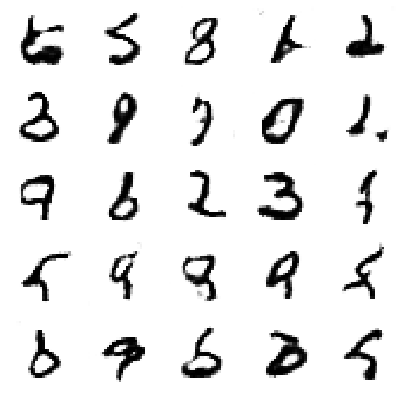

In [0]:
# example of loading the generator model and generating images
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

# load model
model = load_model('models/MNIST/GAN_MNIST_model_090.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)